In [4]:
# forex library
!pip install forex-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 2.8 MB/s eta 0:00:00


In [5]:
# standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings,gc
import datetime
warnings.simplefilter('ignore')


# visualise
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1.5

# forex
from forex_python.converter import CurrencyRates
cr = CurrencyRates()

In [6]:


!ls /content/

!dir C:\Users\Admin\Downloads\


from google.colab import files
upload = files.upload()

sample_data
dir: cannot access 'C:UsersAdminDownloads': No such file or directory


Saving average_hourly_earnings_of_female_and_male_employees_(managers)_local_currency.csv to average_hourly_earnings_of_female_and_male_employees_(managers)_local_currency.csv
Saving countries_short_names_to_convert_currencies.csv to countries_short_names_to_convert_currencies.csv


In [4]:
import zipfile

# Specify the path to the uploaded zip file
zip_file_path = 'archive.zip'

# Specify the directory where you want to extract the contents
extraction_path = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


In [40]:
df = pd.read_csv('average_hourly_earnings_of_female_and_male_employees_(managers)_local_currency.csv', delimiter=',', on_bad_lines='skip')

In [41]:
print(df.columns)


Index(['Unnamed: 0', 'country_id', 'country', 'gender_code', 'gender', 'year',
       'amount_local_currency'],
      dtype='object')


In [42]:
# column filter
df = df.iloc[:,2:]

In [43]:
# data filter
scandinavia = ['Denmark','Norway', 'Sweden', 'Finland', 'Iceland', 'Faroe Islands']
df = df[df['country'].isin(scandinavia)]

In [44]:
# filtering on gender
'''
    because the other codes are Total(T),  Gender Gap (G)
    and not Transgender & Gender Diverse
'''
wanted_gender_code = ['F', 'M']
df = df[df['gender_code'].isin(wanted_gender_code)]

In [45]:
# reset index
df.reset_index(drop=True, inplace=True)

In [46]:
# view
df.head()

,country,gender_code,gender,year,amount_local_currency
0,Denmark,F,Female,2010,35.32
1,Denmark,F,Female,2014,293.30
2,Denmark,F,Female,2018,321.00
3,Iceland,F,Female,2014,4420.00
4,Iceland,F,Female,2015,4850.00


In [47]:
# adjusting for inflation
def inflation_adj(row):

    # get the country name
    country = row['country']

    # get amount
    amount = row['amount_local_currency']

    # CPI Index (as of Jul 2023)
    CPI = {'Denmark': 118.50, 'Iceland': 595.80, 'Sweden': 406, 'Norway': 130.90, 'Finland': 121}

    if country == 'Denmark':
        amount_adj = round((amount * CPI['Denmark'] / 100),3)

    elif country == 'Iceland':
        amount_adj = round((amount * CPI['Iceland'] / 100),3)

    elif country == 'Sweden':
        amount_adj = round((amount * CPI['Sweden'] / 100),3)

    elif country == 'Norway':
        amount_adj = round((amount * CPI['Norway'] / 100),3)

    elif country == 'Finland':
        amount_adj = round((amount * CPI['Finland'] / 100),3)

    else:
        amount_adj = np.nan

    return amount_adj


# apply the function
df['amount_adj_currency'] = df.apply(inflation_adj, axis=1)

# view
df.head()

,country,gender_code,gender,year,amount_local_currency,amount_adj_currency
0,Denmark,F,Female,2010,35.32,41.854
1,Denmark,F,Female,2014,293.30,347.561
2,Denmark,F,Female,2018,321.00,380.385
3,Iceland,F,Female,2014,4420.00,26334.360
4,Iceland,F,Female,2015,4850.00,28896.300


In [48]:
# convert adjusted amount to USD
def curr_convert(row):

    # get the country name
    country = row['country']

    # get the year
    year = row['year']

    # get amount
    amount = row['amount_adj_currency']

    # create date obj
    '''
        assuming date as 31-12-<year>
    '''
    date_obj = datetime.datetime(year, 12, 31)

    if country == 'Denmark':
        amount_usd = round(cr.convert('DKK', 'USD', amount, date_obj),3)

    elif country == 'Iceland':
        amount_usd = round(cr.convert('ISK', 'USD', amount, date_obj),3)

    elif country == 'Sweden':
        amount_usd = round(cr.convert('SEK', 'USD', amount, date_obj),3)

    elif country == 'Norway':
        amount_usd = round(cr.convert('NOK', 'USD', amount, date_obj),3)

    elif country == 'Finland':
        amount_usd = round(cr.convert('EUR', 'USD', amount, date_obj),3)

    else:
        amount_usd = np.nan

    return amount_usd


# apply the function
df['amount_adj_usd_currency'] = df.apply(curr_convert, axis=1)

# view
df.head()

,country,gender_code,gender,year,amount_local_currency,amount_adj_currency,amount_adj_usd_currency
0,Denmark,F,Female,2010,35.32,41.854,7.503
1,Denmark,F,Female,2014,293.30,347.561,56.677
2,Denmark,F,Female,2018,321.00,380.385,58.326
3,Iceland,F,Female,2014,4420.00,26334.360,116.579
4,Iceland,F,Female,2015,4850.00,28896.300,127.921


In [49]:
# custom function
def plot_line(country=None):
    palette = ['#962fbf','#fa7e1e']
    temp = df[df['country'] == country]
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.lineplot(data=temp, x='year', y='amount_adj_usd_currency',hue='gender', palette=palette)
    ax.set_title(f"Adjusted Hourly Earnings (USD) Disparity per Gender in {country}")
    ax.legend(loc="upper left")

    # calculate diff
    max_year = temp.year.max()
    female_amnt = temp[(temp['year'] == max_year) & (temp['gender_code'] == 'F')]['amount_adj_usd_currency'].tolist()[0]
    male_amnt = temp[(temp['year'] == max_year) & (temp['gender_code'] == 'M')]['amount_adj_usd_currency'].tolist()[0]

    if male_amnt > female_amnt:
        diff = round((male_amnt - female_amnt),3)
        print(f"As of 2023, an average male's hourly earning is USD {diff} more than female\n")

    else:
        diff = round((female_amnt - male_amnt),3)
        print(f"As of 2023, an average female's hourly earning is USD {diff} more than male\n")

    plt.show()

As of 2023, an average male's hourly earning is USD 15.263 more than female



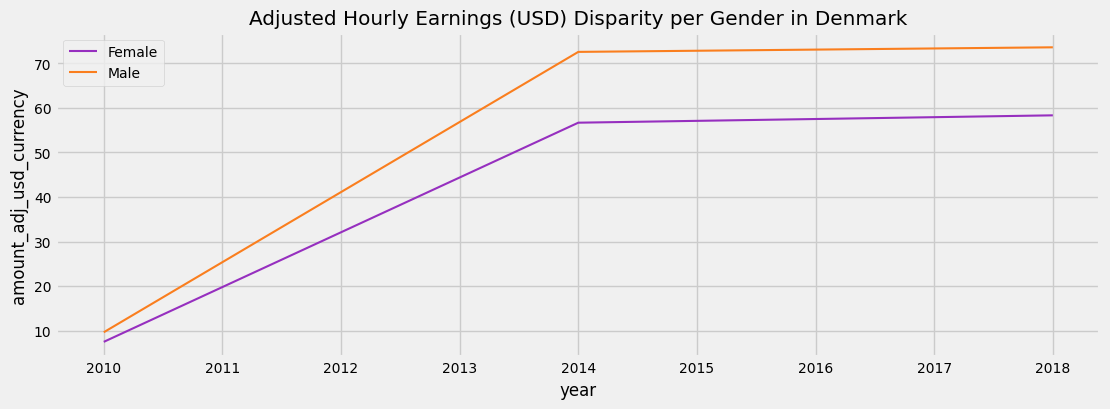

In [50]:
# plot for Denmark
plot_line('Denmark')

As of 2023, an average male's hourly earning is USD 61.72 more than female



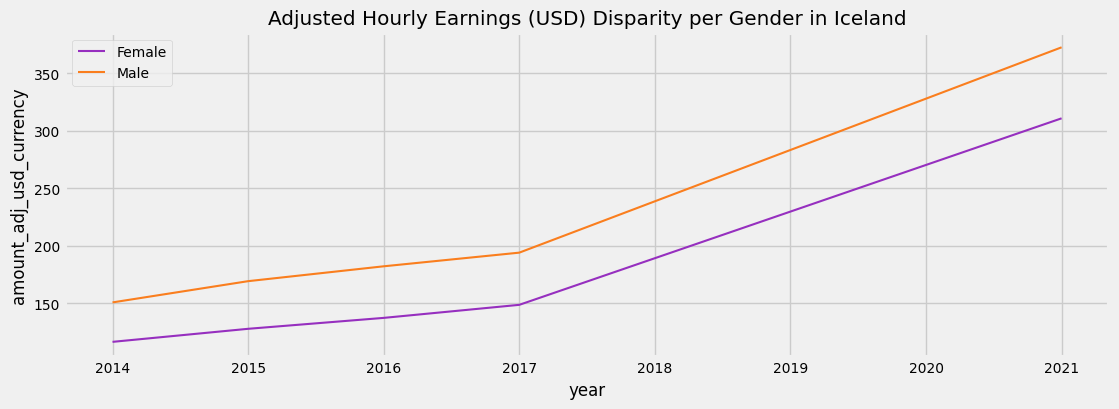

In [51]:
# plot for Iceland
plot_line('Iceland')

As of 2023, an average male's hourly earning is USD 21.101 more than female



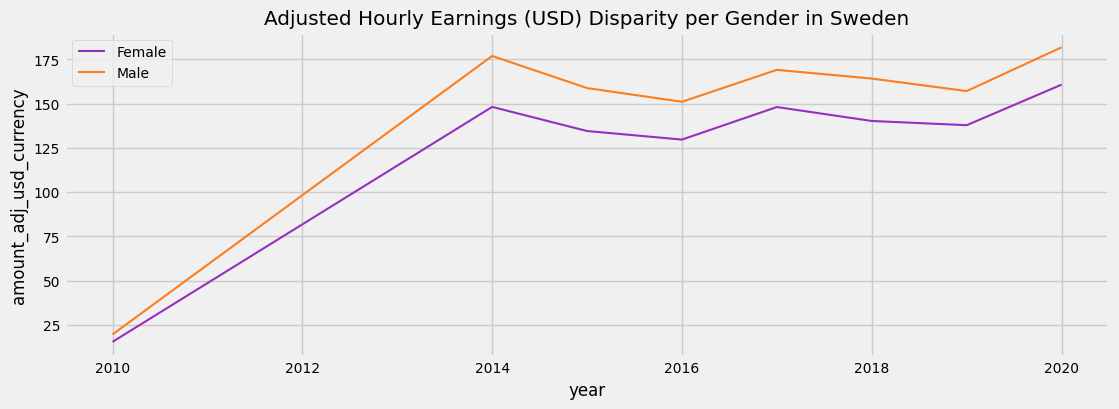

In [52]:
# plot for Sweden
plot_line('Sweden')

As of 2023, an average male's hourly earning is USD 16.573 more than female



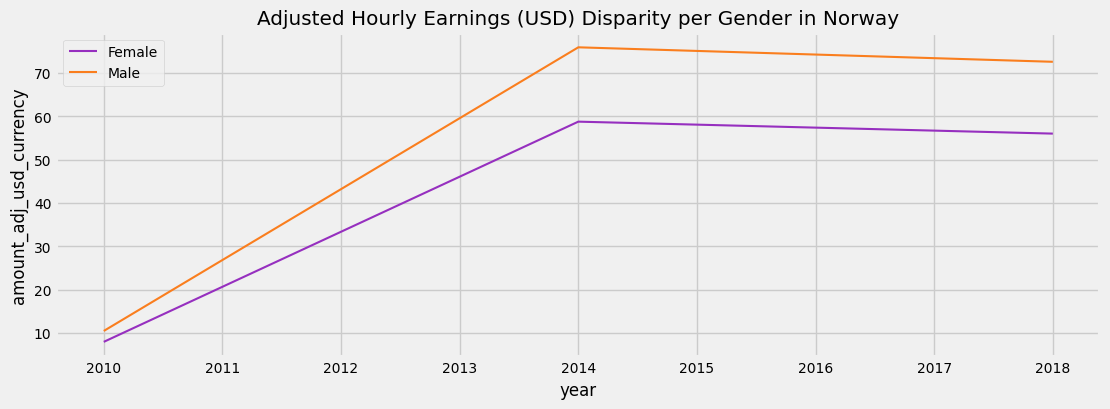

In [53]:
# plot for Norway
plot_line('Norway')

As of 2023, an average male's hourly earning is USD 15.431 more than female



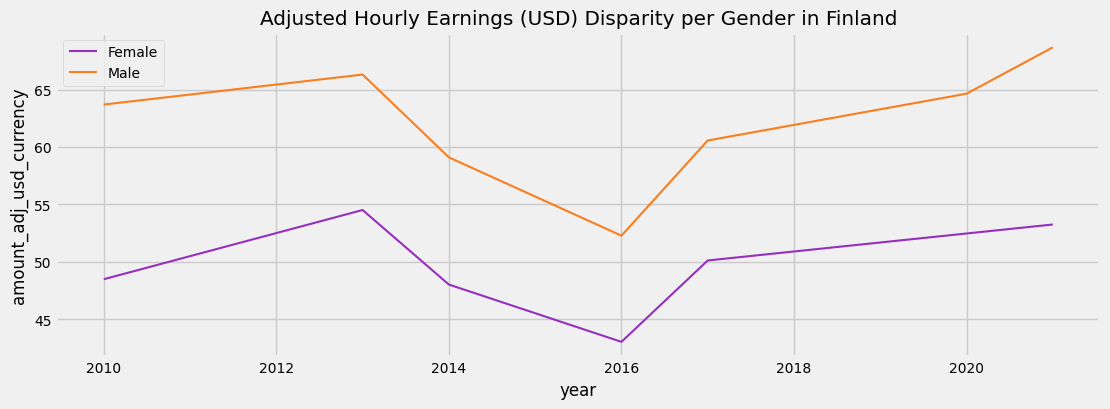

In [54]:
# plot for Finland
plot_line('Finland')

In [ ]:
#Conclusion
#As of 2023, Iceland has the highest earning disparity of USD 61.72 (male > female)
#As of 2023, Denmark & Finland has the lowest earning disparity of ~ USD 15 (male > female)